In [ ]:
pip install transformers accelerate bitsandbytes>=0.39.0 -q

In [ ]:
# model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "microsoft/phi-1_5"

In [ ]:
from transformers import AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto", load_in_4bit=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["A list of colors: red, blue"], return_tensors="pt").to("cuda")

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
generated_ids = model.generate(**model_inputs)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


'A list of colors: red, blue, green, yellow, purple, orange, pink, brown'

In [ ]:
generated_ids

tensor([[   32,  1351,   286,  7577,    25,  2266,    11,  4171,    11,  4077,
            11,  7872,    11, 14032,    11, 10912,    11, 11398,    11,  7586]],
       device='cuda:0')

In [ ]:
tokenizer.pad_token = tokenizer.eos_token  # Most LLMs don't have a pad token by default
model_inputs = tokenizer(
    ["A list of colors: red, blue", "Portugal is"], return_tensors="pt", padding=True
).to("cuda")
generated_ids = model.generate(**model_inputs)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['A list of colors: red, blue, green, yellow, purple, orange, pink, brown',
 'Portugal is a country that is located in western Europe. It is known']

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model=model_name)

 Common pitfalls![quant-freeze.png](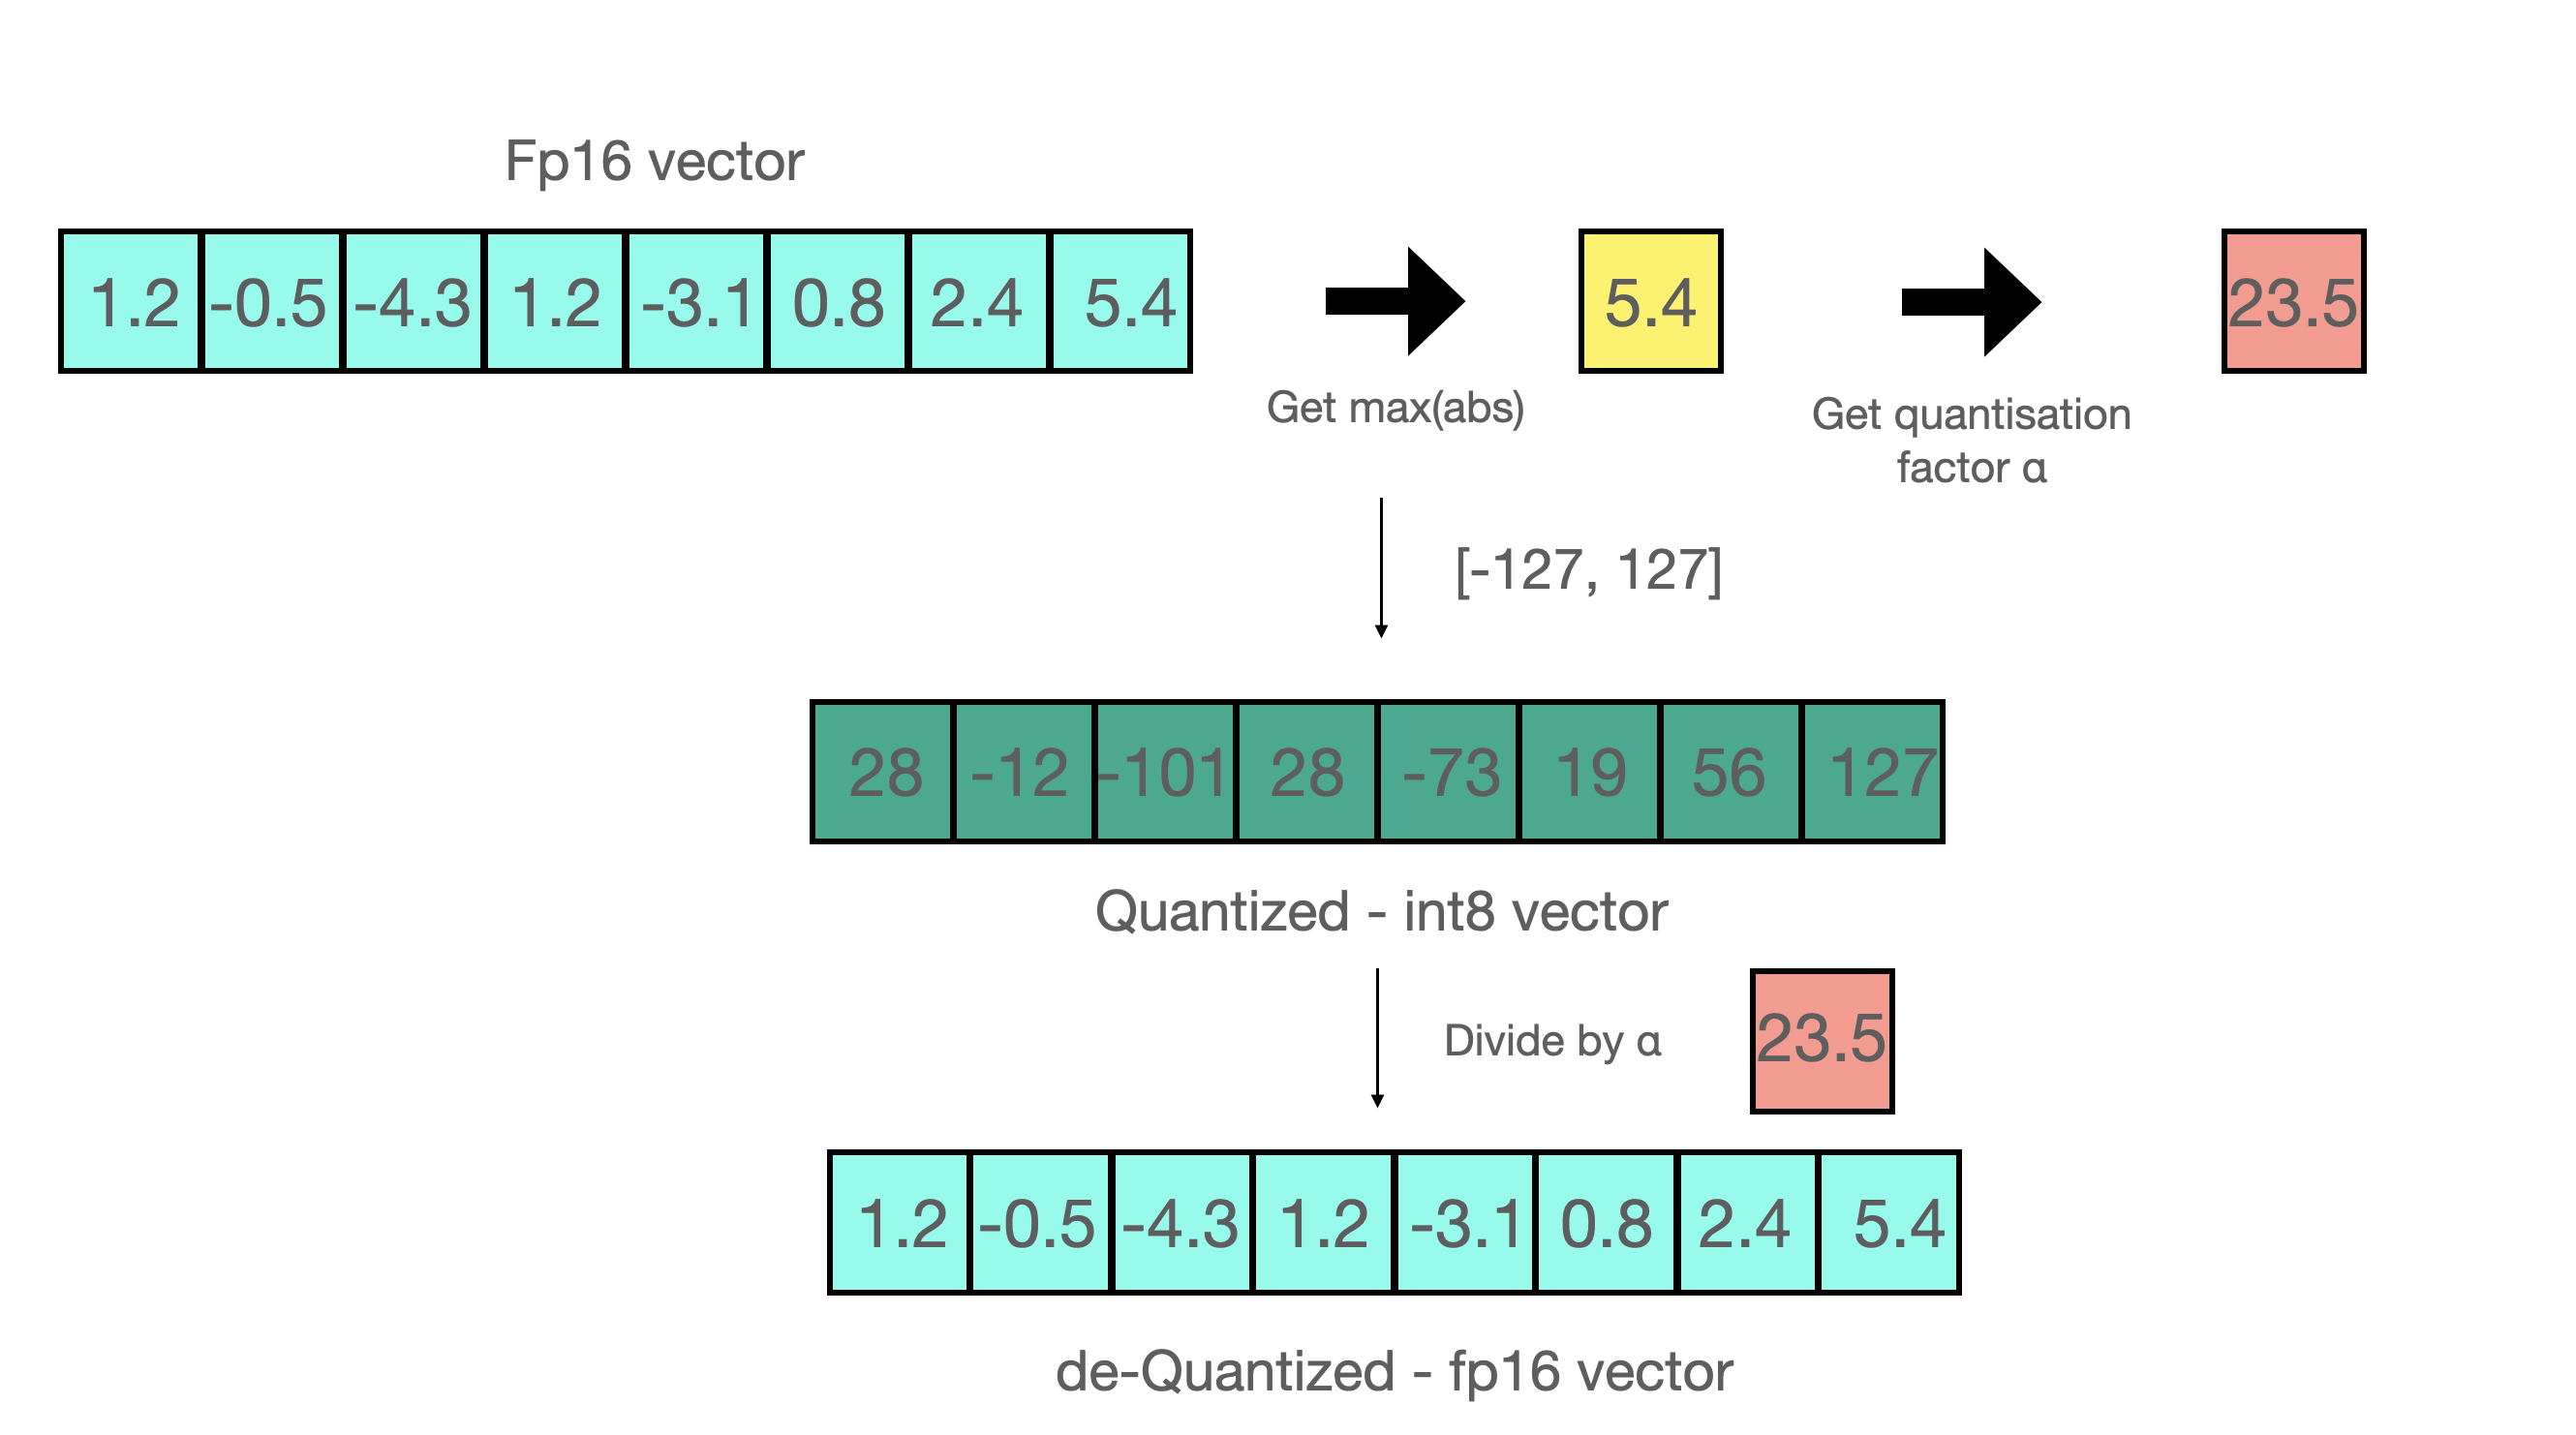![quant-freeze.png](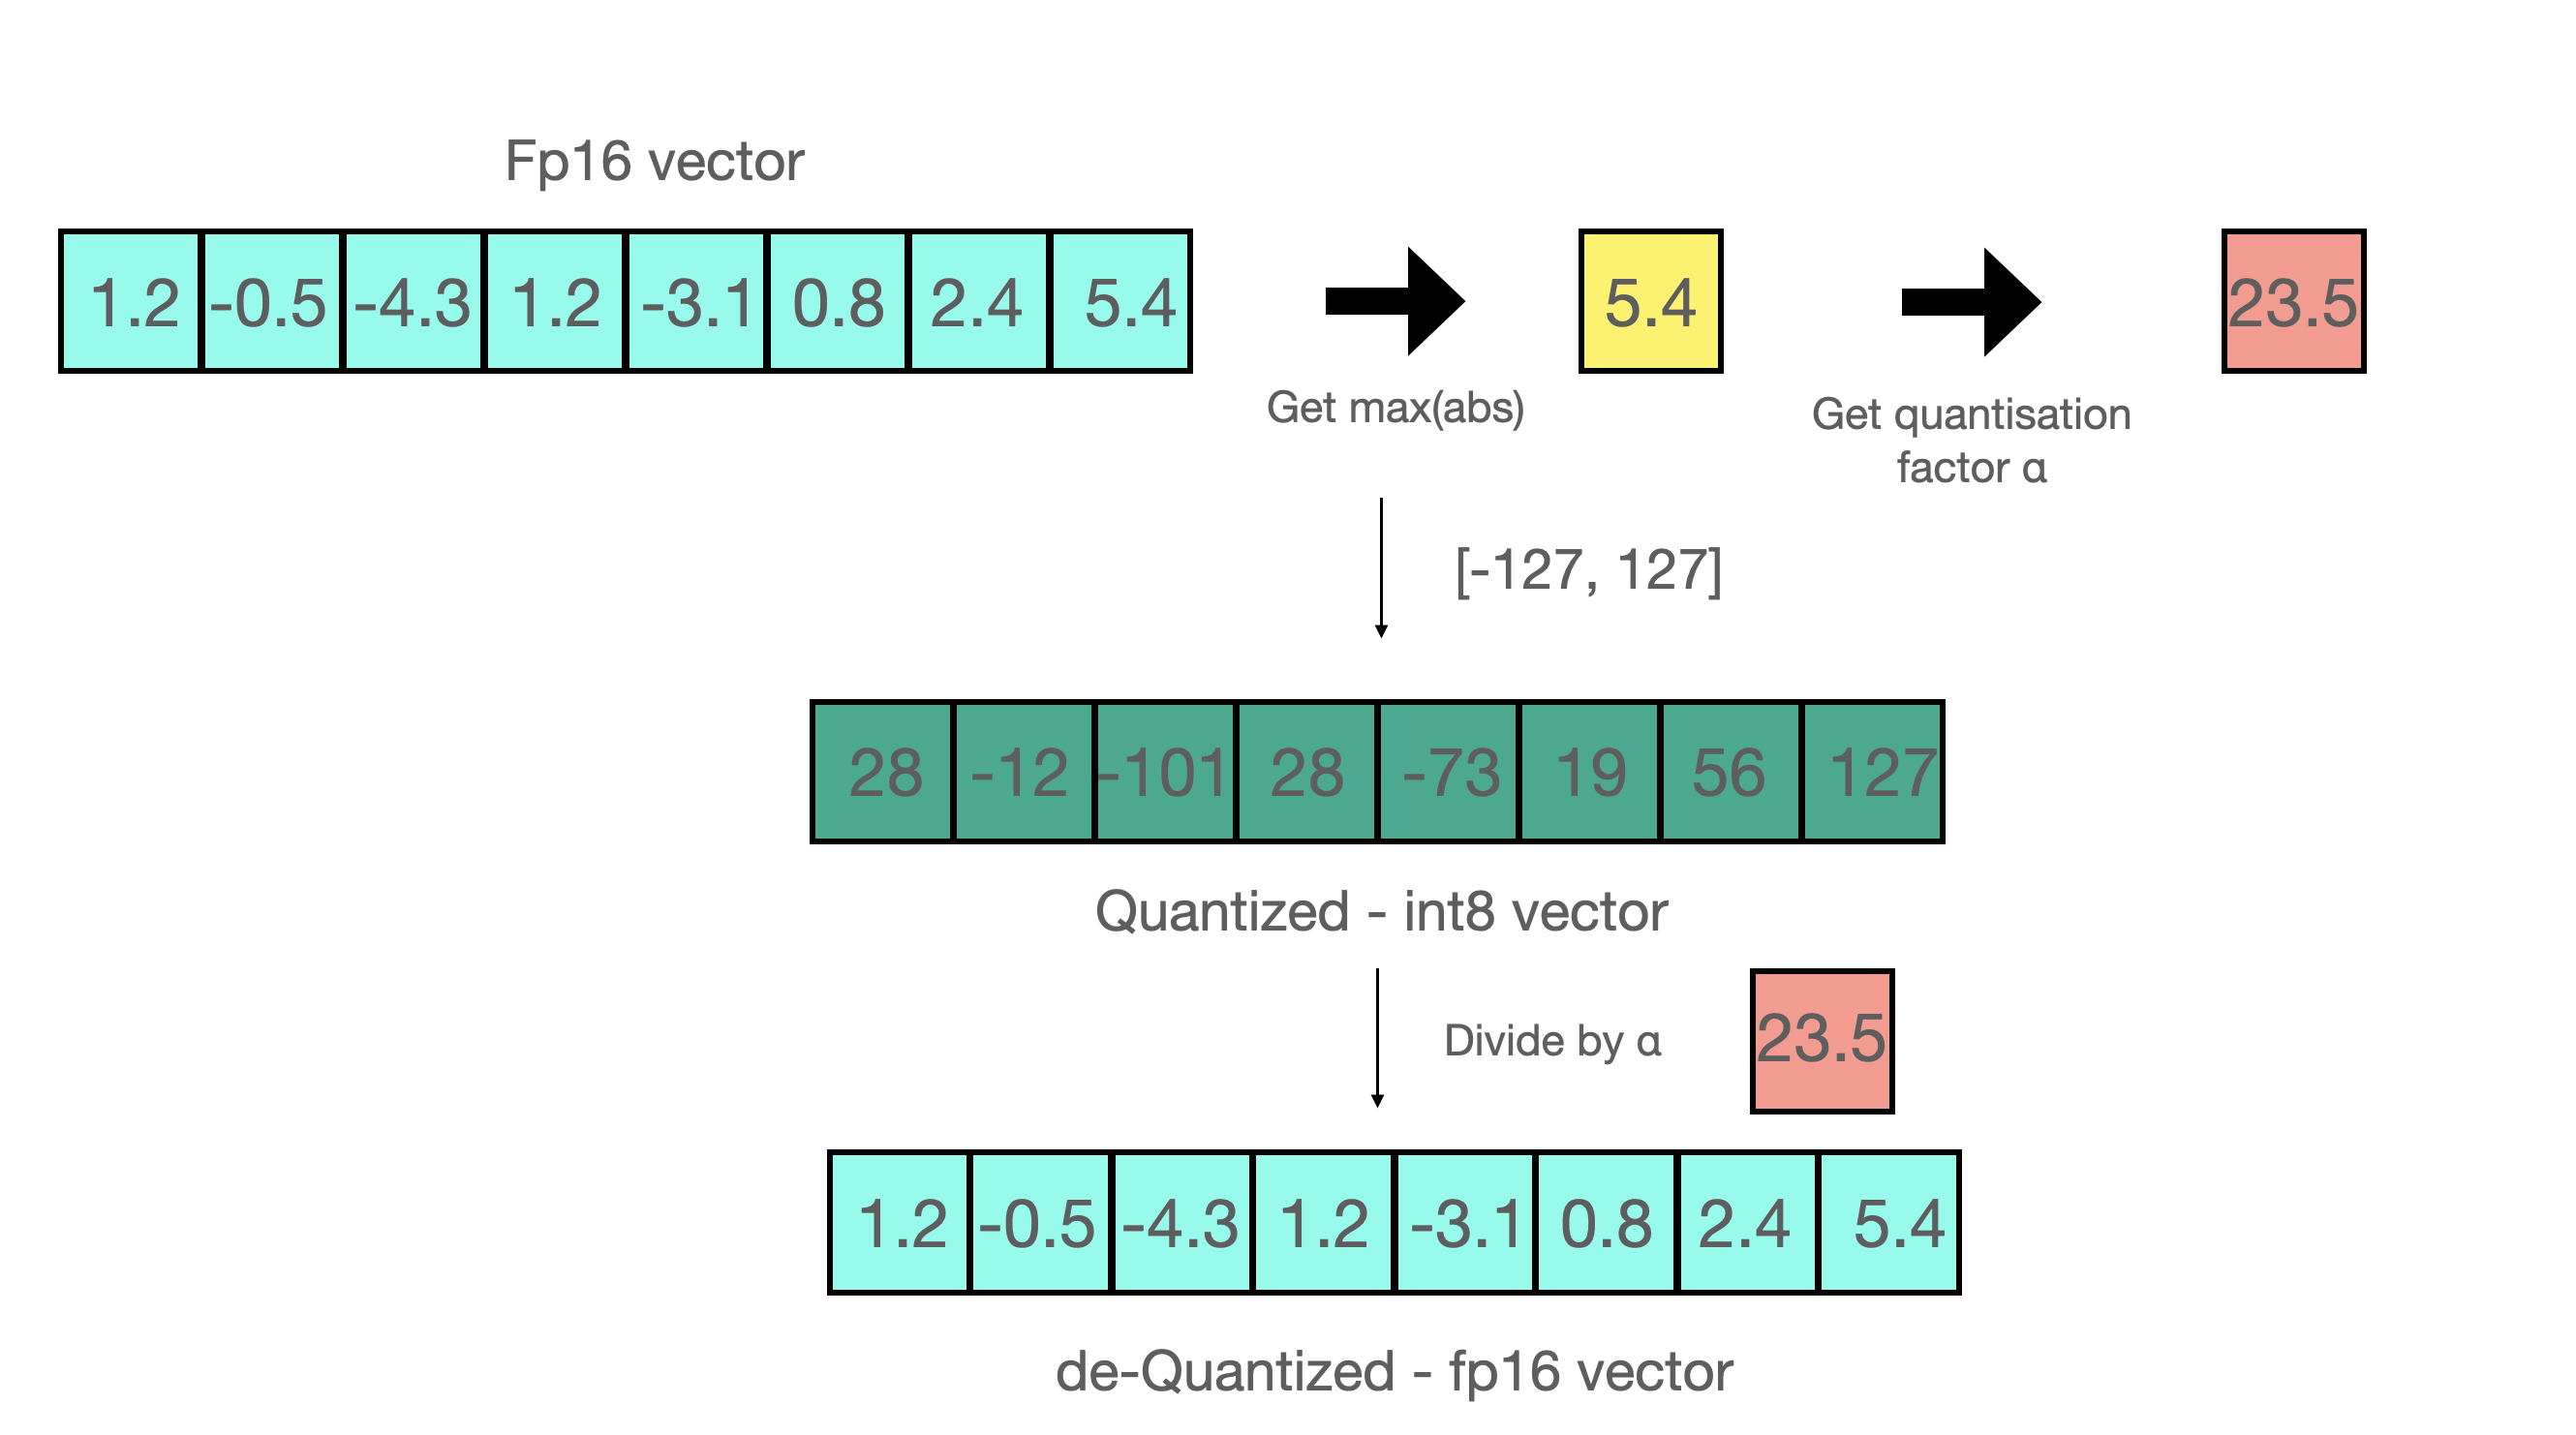![quant-freeze.png](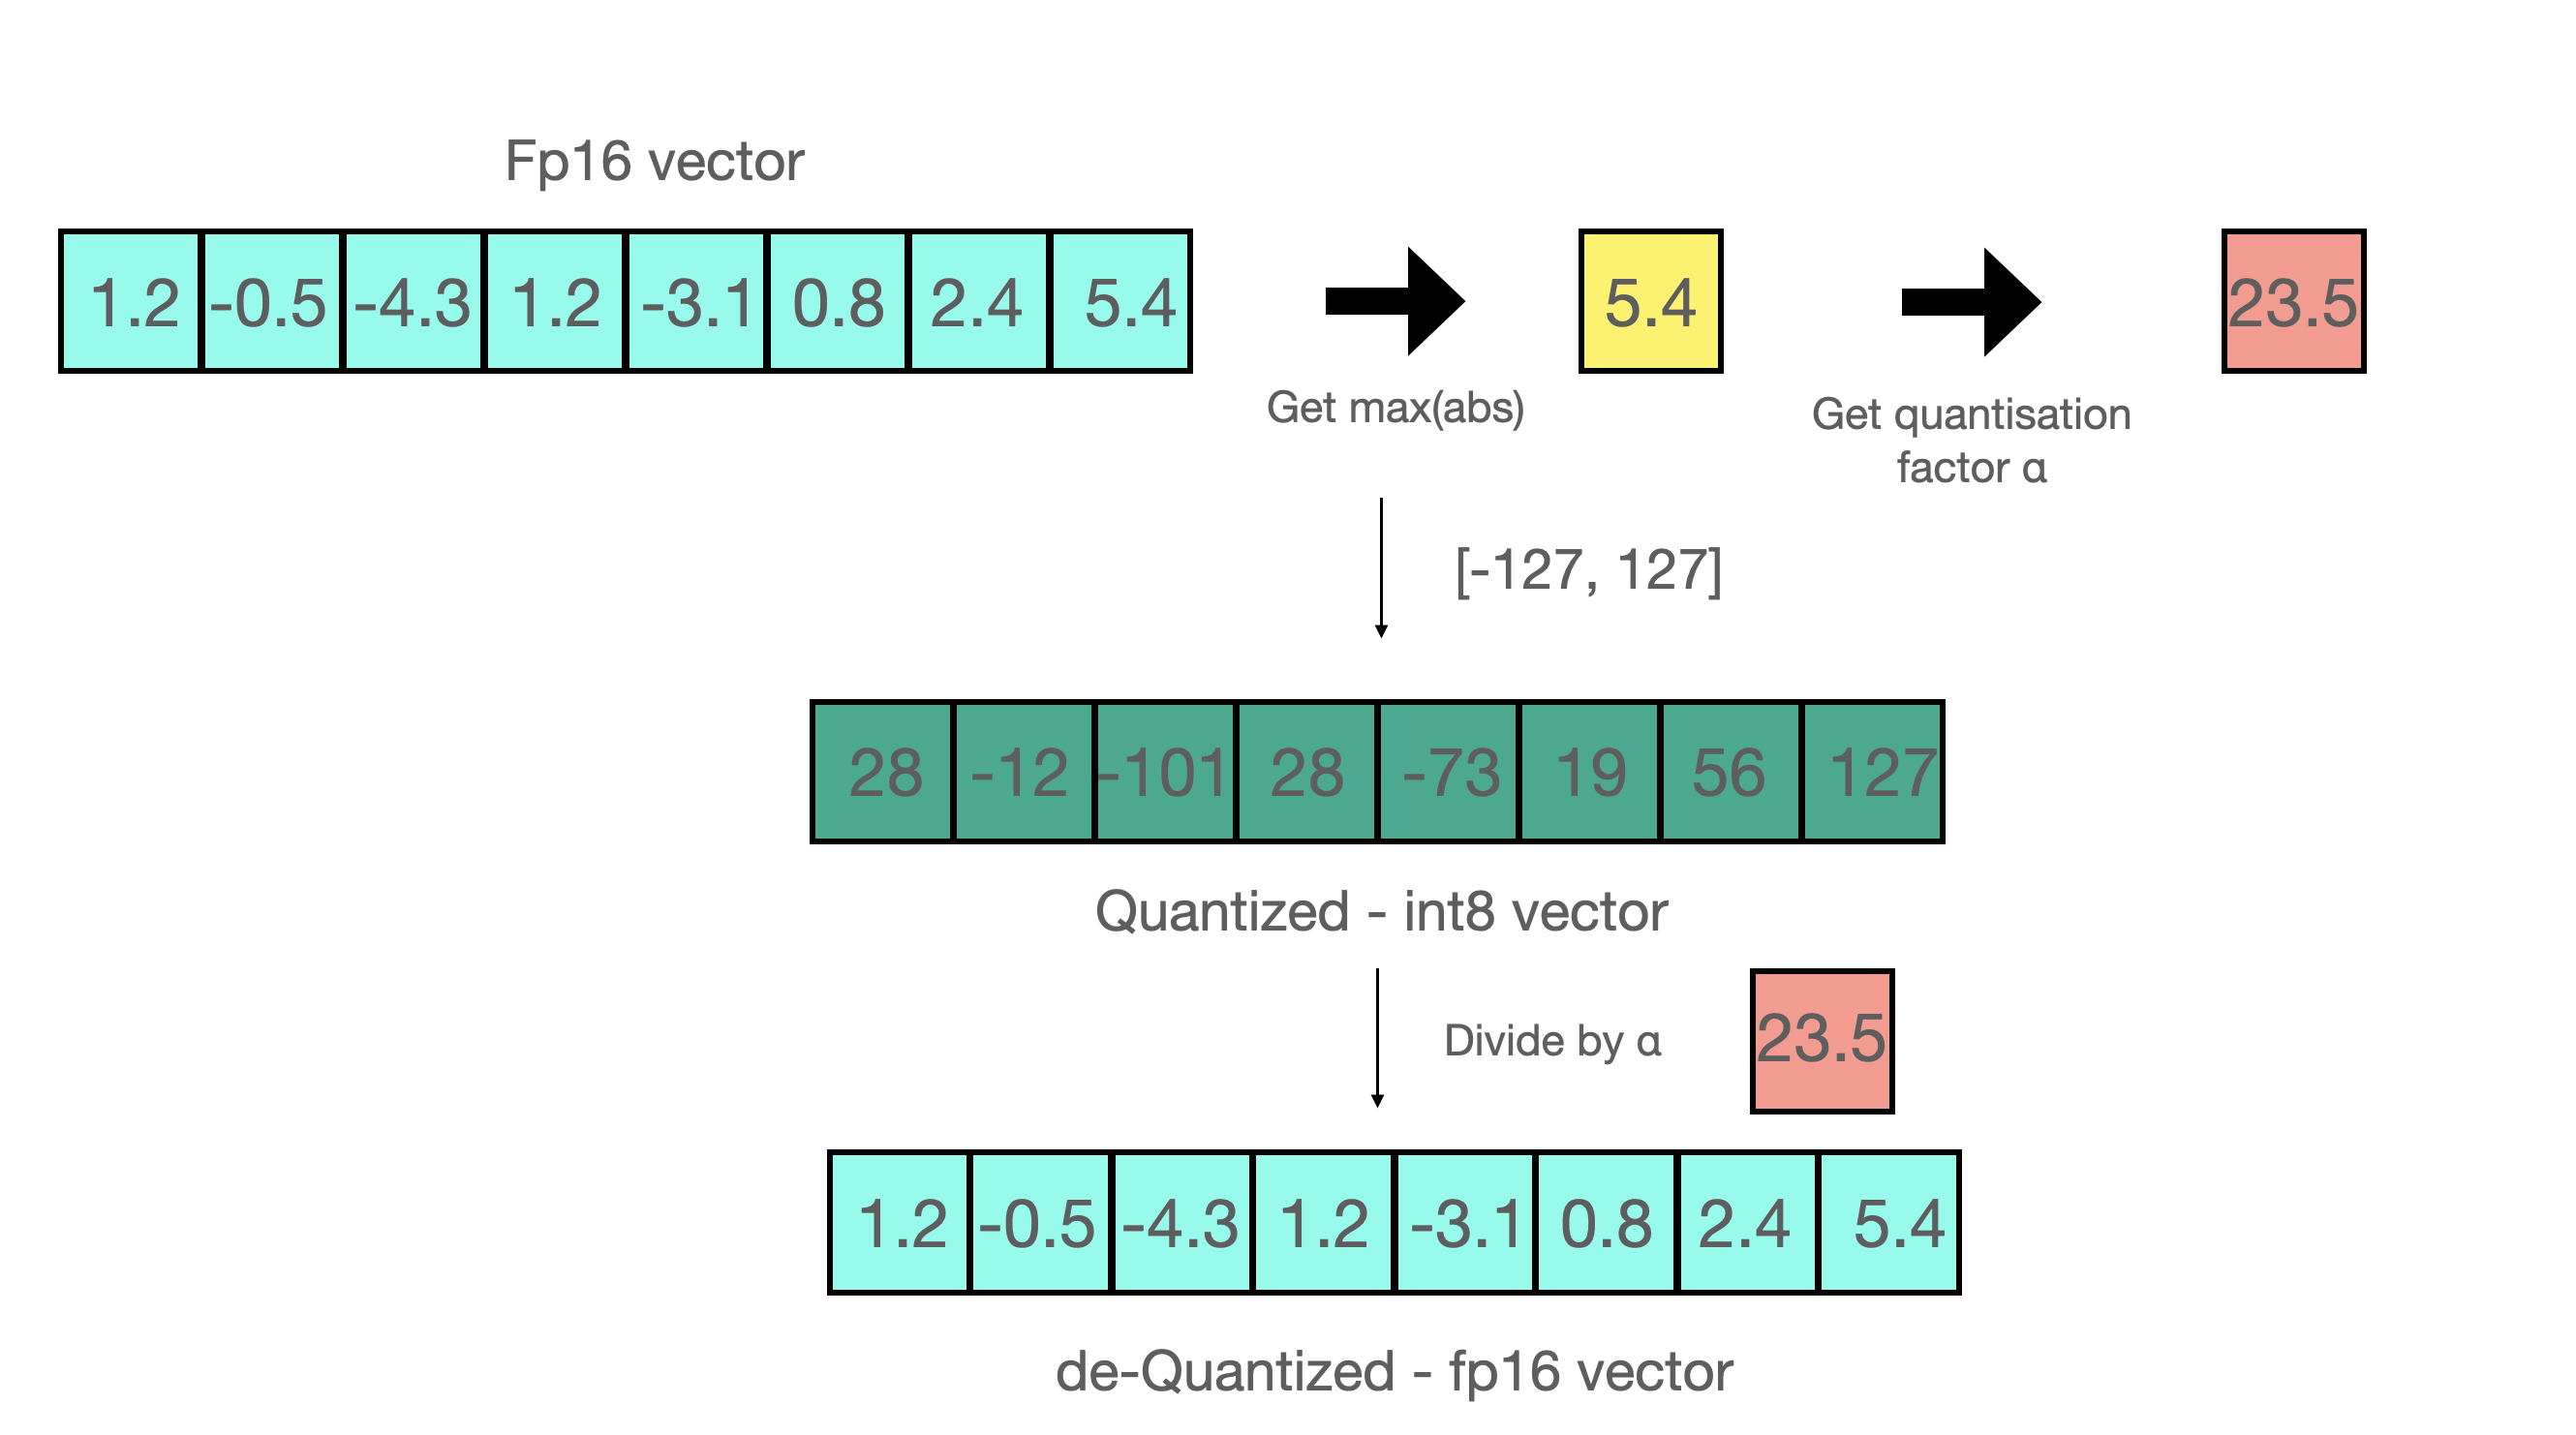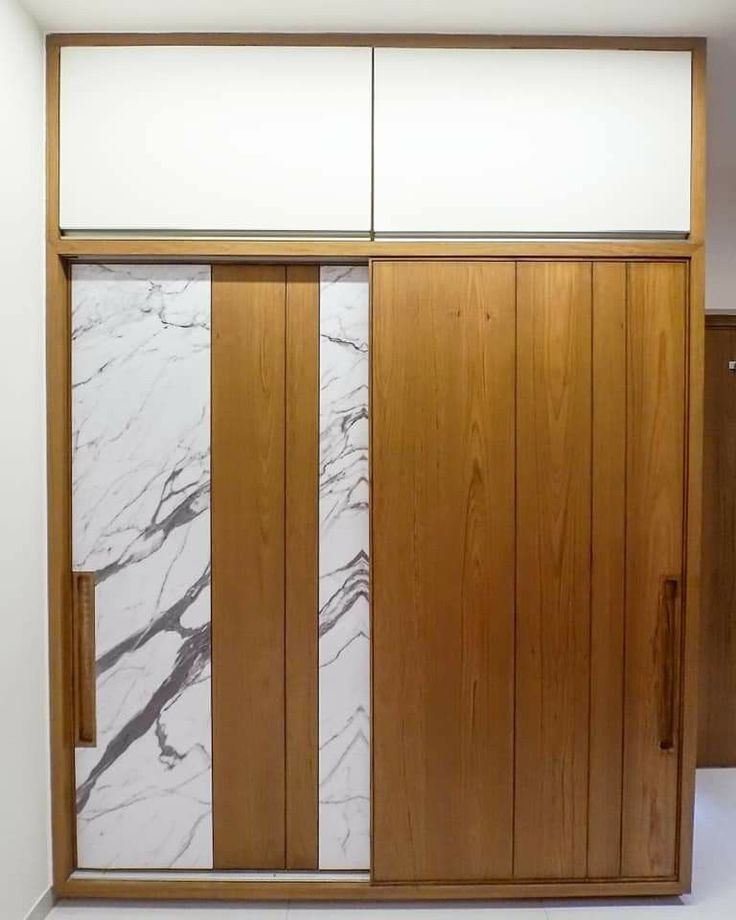)))

In [ ]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (dense): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear4bit(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernor

In [ ]:
model_inputs = tokenizer(["A sequence of numbers: 1, 2"], return_tensors="pt").to("cuda")

# By default, the output will contain up to 20 tokens
generated_ids = model.generate(**model_inputs)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'A sequence of numbers: 1, 2, 3, 4, 5, 6, 7, 8'

In [ ]:
# Setting `max_new_tokens` allows you to control the maximum length
generated_ids = model.generate(**model_inputs, max_new_tokens=50)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

'A sequence of numbers: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10.\n\nExercise 2: Identify the pattern in the following sequence: 2, 4, 6, 8, 10,...\n\nAnswer: The pattern is'

# Quantization

<img src='https://cdn.stackoverflow.co/images/jo7n4k8s/production/5ee6f4e98bf05001b3699344f784adad0177ebe0-688x444.gif?auto=format' width=500px>

  <img src='https://huggingface.co/blog/assets/96_hf_bitsandbytes_integration/quant-freeze.png' width=500px>